<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler


import os
import gc
from time import time

!pip install catboost

     |████████████████████████████████| 63.9MB 47kB/s 


In [11]:
from google.colab import files, drive

drive.mount('/content/gdrive')
%cd /content/gdrive/"My Drive"
!unzip ieee-fraud-detection.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
Archive:  ieee-fraud-detection.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [12]:
train_id = pd.read_csv('train_identity.csv')
train_action = pd.read_csv('train_transaction.csv')
test_id = pd.read_csv('test_identity.csv')
test_action = pd.read_csv('test_transaction.csv')

# Merge datasets: not all transaction record has corresponding Identity informationb
train = train_action.merge(train_id, on = 'TransactionID', how = 'left')
test = test_action.merge(test_id, on = 'TransactionID', how = 'left')
del train_action, test_action, train_id, test_id
gc.collect()

0

*We* have 590000 training samples, and over 400 feature in total. 
We may need feature selection for FE.

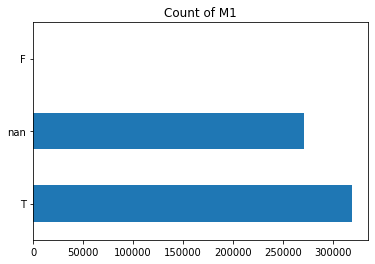

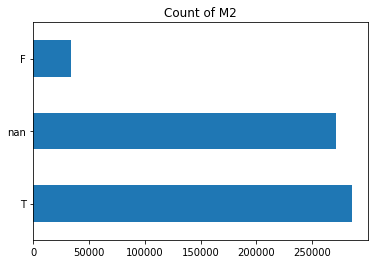

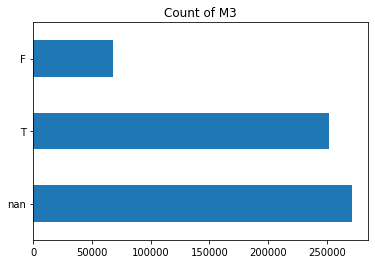

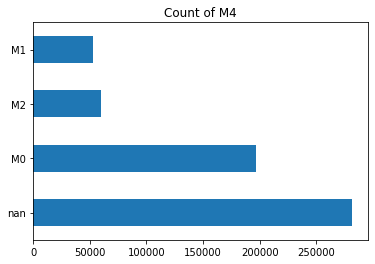

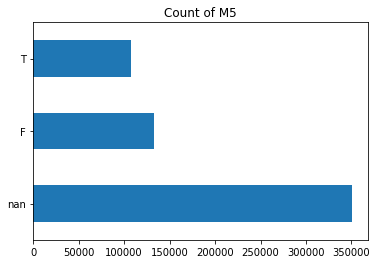

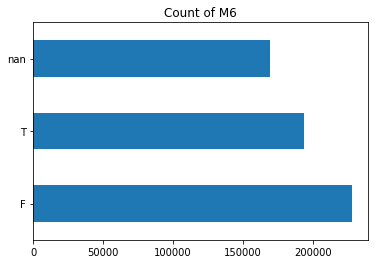

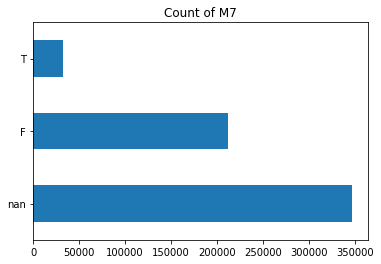

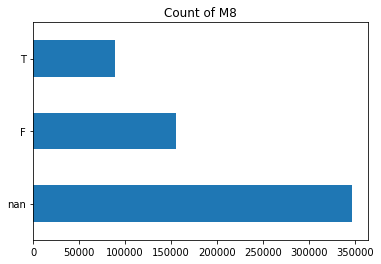

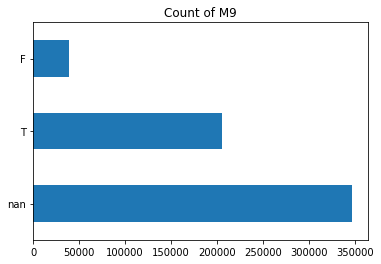

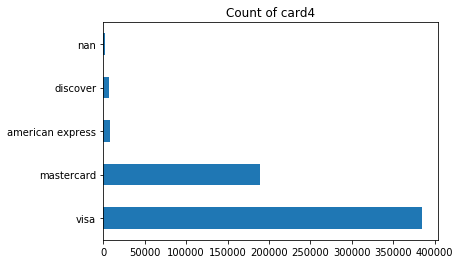

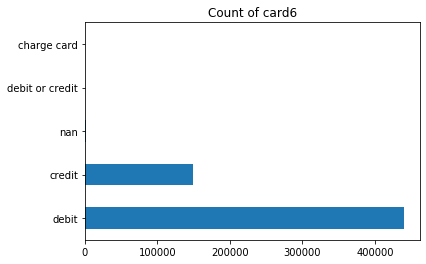

27235

In [0]:
# EDA

# Too many feature, we need feature selection afterward
'''
plt.hist(train['TransactionDT'], label = 'train')
plt.hist(test['TransactionDT'], label = 'test')
plt.legend()
plt.show()
'''
'''
print('{:.2f} % of transaction data is Fraud. '.format(train['isFraud'].mean()*100))
print('Mean Transaction Amount Fraud: ', train.loc[train['isFraud'] == 1, 'TransactionAmt'].mean())
print('Mean Transaction Amount Not Fraud: ', train.loc[train['isFraud'] == 0, 'TransactionAmt'].mean())
# Fraud transaction tends to pay higher than not fraud
'''
# Show observation of each product
# Plot feature that are unknowna and not clear for it's values
show_feature = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'card4', 'card6']
 
for feat in show_feature:
   plt.figure()
   train[feat].value_counts(dropna = False).plot(
      kind = 'barh', # horizantal bar plot
      title = f'Count of {feat}'
)
plt.show()


gc.collect()

In [0]:
print(train['card1'].value_counts())

print(train['card1'].value_counts(normalize = True))

gc.collect()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dtype: int64
7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
           ...   
12390    0.000002
10341    0.000002
10006    0.000002
15743    0.000002
17105    0.000002
Name: card1, Length: 13553, dtype: float64


13

In [0]:
# Feature engineering

# For safety, replace infinite value in dataframe with nan
def remove_inf(df):
  return df.replace([np.inf, -np.inf], np.nan)
  
le = LabelEncoder()  
def preprocessing(df_train, df_test):
  '''
  Feature engineering for dataframe.
  FE that involves train data & test data: 
  Categorical encoding: train & test feature might contain categorical value that each other don't have.
  Drop feature: Features that analysed to drop such as many-nan feature, may vary in train & test data. The determined drop feature should be
  remove simultaneously in both dataset.
  '''
  drop_feature = []

  # Feature Generation

  # Email feature split
  df_train[['P_email1', 'P_email2', 'P_email3']] = df_train['P_emaildomain'].str.split('.', expand = True)
  df_train[['R_email1', 'R_email2', 'R_email3']] = df_train['R_emaildomain'].str.split('.', expand = True)
  df_test[['P_email1', 'P_email2', 'P_email3']] = df_test['P_emaildomain'].str.split('.', expand = True)
  df_test[['R_email1', 'R_email2', 'R_email3']] = df_test['R_emaildomain'].str.split('.', expand = True)
  drop_feature = list(set(drop_feature + ['P_emaildomain', 'R_emaildomain']))

  # Feature selection
  # Features that contains 90% null values
  drop_nan_train = list(df_train.isnull().sum()[df_train.isnull().sum() > int(df_train.shape[0]*0.9)].index)
  drop_nan_test = list(df_test.isnull().sum()[df_test.isnull().sum() > int(df_test.shape[0]*0.9)].index)
  drop_feature = list(set(drop_feature + drop_nan_train + drop_nan_test))
  # Feature that contains 90% same unique values
  big_top_train = [col for col in df_train.columns if df_train[col].value_counts(
      dropna = False, normalize = True).values[0] >= 0.9]
  big_top_test = [col for col in df_test.columns if df_test[col].value_counts(
      dropna = False, normalize = True).values[0] >= 0.9]    
  drop_feature = list(set(drop_feature + big_top_train + big_top_test))

  # Feature transformation
  # Encode categorical feature
  obj_feature = list(df_train.select_dtypes(include = 'object').columns)
  for feat in obj_feature:
     le.fit(list(df_train[feat].astype(str).values) + list(df_test[feat].astype(str).values))
     df_train[feat] = le.transform(df_train[feat])
     df_test[feat] = le.transform(df_test[feat])
  # Numerical feature: fillna
  num_feature = list(df_train.select_dtypes(exclude = 'object'))
  for f in num_feature:
      df_train[f] = df_train[f].fillna(df_train[f].mean(), inplace = False)
      df_test[f] = df_test[f].fillna(df_test[f].mean(), inplace = False)

  # Data cleaning
  # fill missing
  drop_feature.remove('isFraud')
  print('Length of dropped features: ', len(drop_feature))
  df_train.drop(drop_feature, axis = 1, inplace = True)
  df_test.drop(drop_feature, axis = 1, inplace = True)

  # Normalization
  # Apply on num_feature except isFraud
  #scaler = StandardScaler()
  #df_x = scaler.fit_transform(df_x)

  return df_train, df_test

In [0]:
from catboost import CatBoostClassifier
from sklearn import metrics
from numba import jit

# Compute roc_auc quickly
@jit # 將此function 變成jit的object, 即時編譯，使運算速度加快
def fast_auc(y_true, y_prob):
  y_true = np.array(y_true)
  y_true = y_true[np.argsort(y_prob)] #??
  n_false = 0
  auc = 0
  n = len(y_true)
  for i in range(n): # for each sample
    y_i = y_true[i]
    n_false += (1 - y_i)
    auc += y_i * n_false
  
  auc /= (n_false * (n - n_false))
  return auc


def eval_auc(y_true, y_pred):
  # Fast auc evaluation for lgb
  return 'auc', fast_auc(y_true, y_pred), True

def train_model_classification(x, x_test, y, params, 
                               folds, splits = None, n_folds = 3,
                               columns = None, 
                               model_type = 'lgb', eval_metric = 'auc', model = None,
                               n_estimators = 50000, 
                               verbose = 10000, early_stopping_rounds = 200,
                               ):
  '''
  Function to train variety of classification models.
  Return: out-of-fold predictions, test_prediction, score
  x: training data, dataframe or array, after normalization
  y: training target
  folds: folds to split data
  model_type: determine what model to use
  eval_metric: meric to use in this problem, applied for all the models
  columns: selected columns to use for training, if specified
  model: sklearn model
  n_estimators: number of boosters for boosting model
  '''
  columns = x.columns if columns is None else columns # If we don't give selected feature, then train columns is columns to use
  n_splits = folds.n_splits if splits is None else n_folds
  x_test = x_test[columns]
  # set up scoring parameters for different models
  model_metric = {
      'auc':{
          'lgb_metric':eval_auc,
          'catboost_metric':'AUC',
          'sklearn_scoring_function':roc_auc_score
      }
  }

  result_dict = {}
  # out-of-hold prediction on train data
  oof = np.zeros((len(x), 1))
  prediction = np.zeros((len(x_test), 1)) # prediction on test data

  # list of scores on folds
  score = [] # model's scoring performance for each fold data
  feature_importance = pd.DataFrame()

  for fold_n, (train_id, valid_id) in enumerate(fold.split(x)):
     '''
     Train different model and: 
     1. show performance for each fold  2. Predict for test set
     '''
     print(f'Fold {fold_n + 1} at time {time.ctime()}')
     x_train, x_valid = x.iloc[train_id], x.iloc[valid_id]
     y_train, y_valid = y.iloc[train_id], y.iloc[valid_id]

     if model_type == 'lgb':
        model = LGBMClassifier(**params,
                              n_estimators = n_estimators,
                              n_jobs = -1)
    
        model.fit(x_train, y_train,
                  verbose = verbose,
                  early_stopping_rounds = early_stopping_rounds,
                  eval_set = [(x_valid, y_valid)],
                  eval_metric = model_metric[eval_metric]['lgb_metric'])
    
        y_valid_pred = model.predict_proba(x_valid)[:, 1] # predict probability for each valid sample
        y_pred = model.predict_proba(x_test, 
                                     num_iteration = model.best_iteration_) # use optimize number of trees for prediction

     if model_type == 'sklearn':
        model = model
        model.fit(x_train, y_train)
        y_valid_pred = model.predict(x_valid).reshape(-1,)
        score = model_metric[eval_metric]['sklearn_scoring_function'](y_valid, y_valid_pred)
        print(f'Fold {fold_n + 1} have {eval_metric} score: {score:.4f}')
        y_pred = model.predict_proba(x_test)

     if model_type == 'cat':
        model = CatBoostClassifier(**params,
                                   iterations = n_estimators,
                                   eval_metric = model_metric[eval_metric]['catboost_metric'],
                                   loss_function = Logloss
                                   )
        
        model.fit(x_train, y_train, verbose = False,
                  eval_set = (x_valid, y_valid), cat_feature = [],
                  use_best_model = True,
                  )
        y_valid_pred = model.predict_proba(x_valid)
        y_pred = model.predict_proba(x_test)

     oof[valid_id] = y_valid_pred.reshape(-1, 1) # size of all hold-out-set should be smaller than whole X
     score.append(model_metric[eval_metric]['sklearn_scoring_function'](y_valid, y_valid_pred))
     # Average over predictions on all hold-out-set
     prediction += y_pred.reshape((-1, 1))

  prediction /= n_splits
  print('CV mean score: {0:.4f}, std: {1:.4f}'.format(np.mean(score), np.std(score)))

  result_dict['oof'] = oof
  result_dict['score'] = score
  result_dict['prediction'] = prediction

  return result_dict


In [17]:
# Training:
# 1. Select the model, apply GridsearchCV to select the best parameters
# 2. Retrain the model with the best parameters
# 3. Make predictions on the test data
train_data, test_data = preprocessing(train, test)
x_train = train_data.sort_values['TransactionDT'].drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
y_train = train_data.sort_values['TransactionDT']['isFraud']
x_test = test_data.drop(['TransactionID', 'TransactionDT'], axis = 1)
del train, train_data

k_fold = TimeSeriesSplit(n_splits = 5)



ValueError: ignored

In [0]:
# Lightgbm

parames = {
    'num_leaves':256,
    'max_depth':15,
    'learning_rate':0.05,
    'metric':'auc',
    'reg_alpha':0.3,
    'reg_lambda':0.3,
    'verbosity':-1
}

result_dict_lgb = train_model_classification(
    x_train, x_test, y_train, params, n_fold, model_type = 'lgb',
    eval_metric = 'auc', verbose = 500,
    early_stopping_rounds = 200, n_estimators = 5000
)


In [0]:
# Logistic regression
logit = LogisticRegression(
    penalty= 'l2',
    verbose = 50,
    random_state = 99)
logit.fit(x_data, y_data)
print('ROC accuracy: ', roc_auc_score(y_valid, logit.predict(x_valid)))

del train_
gc.collect()

Current ROC AUC: 0.57